In [1]:
import re
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
# --- 1. Data: some text ---
DEFAULT_RUSSIAN_EXCERPT = """
Мой дядя самых честных правил,
Когда не в шутку занемог,
Он уважать себя заставил
И лучше выдумать не мог.
Его пример другим наука;
Но, боже мой, какая скука
С больным сидеть и день и ночь,
Не отходя ни шагу прочь!
"""
DEFAULT_EN_EXCERPT = """
My uncle, man of firm convictions,
By falling gravely ill, he's won
A due respect for his afflictions —
The only clever thing he's done...
But God, what deadly boredom, tending
A sick man day and night, attending
Him to and fro without a pause!
"""

## or load in a scipt, but set this as deafult
TEXT = DEFAULT_RUSSIAN_EXCERPT.strip()

VOWELS = set("аеёиоуыэюяАЕЁИОУЫЭЮЯ")
SCRIPT = "Cyrillic (Russian)"

# VOWELS_ENG = set("aeiouyAEIOUY")
# SCRIPT_ENG = "Latin (English)"

In [3]:
# --- 3. Clean and categorise characters to V/C sequence ---
def letters_only(text: str) -> str:
    # Keep letters from script; drop everything else - ;,?/...
    return "".join(re.findall(r"[A-Za-zА-Яа-яЁё]", text))

LETTERS = letters_only(TEXT)


## list with classifiying states - letter is either V or C  
def to_states(letters: str) -> list:
    states = []
    for ch in letters:
        # print(ch)
        if ch in VOWELS:
            states.append('V')

        else:
            # Everything that's a letter but not a vowel is "C"
            states.append('C')
    return states

## Vowel or Consonant  - states list 
states = to_states(LETTERS)

# Safety check: ensure we have at least some transitions
if len(states) < 2:
    raise ValueError("Not enough letters in the input text to build a Markov model.")

# LETTERS, 
len(states)

167

In [5]:
# --- 4. Build transition counts and Markov matrix ---
STATE_INDEX = {'V': 0, 'C': 1}
INDEX_STATE = {0: 'V', 1: 'C'}

# For each category/state in the list V/C, make binary variables - 1 or 0 if state V or C 
counts = np.zeros((2, 2), dtype=int)
for a, b in zip(states[:-1], states[1:]):
    i, j = STATE_INDEX[a], STATE_INDEX[b] 
    # create 1-0 matrices - rows sumto 1 Pr(Xt+1​=j∣Xt​=i,Xt−1​,…)
    counts[i, j] += 1 # add one to the correct matrix element - > make 2 by 2 individual transition matrix 
    # print(counts)

print(f"Final transition matrix sum \n {counts}")
print(" ")

# Row sum
row_sums = counts.sum(axis=1, keepdims=True)
print(f"Row sum of transition matrix \n {row_sums}") # 68 V by 98 C
print(" ")
with np.errstate(divide='ignore', invalid='ignore'):
    P = counts / np.where(row_sums == 0, 1, row_sums)  # avoid divide-by-zero with a safe guard

print(f"Transition matrix normalised: \n {P}")


Final transition matrix sum 
 [[ 3 65]
 [65 33]]
 
Row sum of transition matrix 
 [[68]
 [98]]
 
Transition matrix normalised: 
 [[0.04411765 0.95588235]
 [0.66326531 0.33673469]]


In [6]:
# --- 5. Empirical frequencies and stationary distribution ---
emp_counts = Counter(states)
emp_freq = np.array([emp_counts['V'], emp_counts['C']], dtype=float)
emp_freq /= emp_freq.sum()

print(f"emp_counts {emp_counts}, emp_freq {emp_freq}")

# Stationary distribution pi solves pi P = pi and sum(pi)=1
# For a 2x2, we can do it analytically; but a generic method:
w, v = np.linalg.eig(P.T)

## stationery dist:
# Find eigenvector with eigenvalue closest to 1
idx = np.argmin(np.abs(w - 1))
pi = np.real(v[:, idx])
pi = pi / pi.sum()

print(" ")
print(f"Stationary distribution pi: \n {pi}")

emp_counts Counter({'C': 99, 'V': 68}), emp_freq [0.40718563 0.59281437]
 
Stationary distribution pi: 
 [0.40963855 0.59036145]


In [18]:
# --- 6. Run-length analysis ---

# Empirical PMF
def run_lengths(seq, target):
    """Return list of lengths of consecutive runs of `target` in `seq`."""
    lengths = []
    current = 0
    for s in seq:
        if s == target:
            current += 1
        else:
            if current > 0:
                lengths.append(current)
            current = 0
    if current > 0:
        lengths.append(current)
    return lengths

runs_V = run_lengths(states, 'V')
runs_C = run_lengths(states, 'C')
len(runs_V), len(runs_C)

(65, 66)

In [ ]:
print(P)
P[STATE_INDEX['V'], STATE_INDEX['V']] ## V to V 

[[0.04411765 0.95588235]
 [0.66326531 0.33673469]]


np.float64(0.04411764705882353)

In [ ]:
# Theoretical geometric PMF for run lengths in a 2-state chain:
# P(L = l) = (1 - p_ss) * (p_ss)^(l-1), l=1,2,3,... where p_ss = P[s,s]
p_VV = P[STATE_INDEX['V'], STATE_INDEX['V']] 
p_CC = P[STATE_INDEX['C'], STATE_INDEX['C']]

def geom_pmf(l_max, p_ss):
    l = np.arange(1, l_max + 1)
    pmf = (1 - p_ss) * (p_ss ** (l - 1))
    return l, pmf

max_l_V = max(runs_V) if runs_V else 1
max_l_C = max(runs_C) if runs_C else 1
print(max_l_V, max_l_C)

lV, pmfV = geom_pmf(min(max_l_V, 15), p_VV)
lC, pmfC = geom_pmf(min(max_l_C, 15), p_CC)

print(pmfV, lV)
print(pmfC, lC)

2 3
[0.95588235 0.04217128] [1 2]
[0.66326531 0.22334444 0.07520782] [1 2 3]


In [ ]:
# ---------- ITMO palette ----------
ITMO_VIOLET     = (126/255, 16/255, 1.0, 1.0)
ITMO_VIOLET_60  = (126/255, 16/255, 1.0, 0.6)
ITMO_YELLOW     = (1.0, 1.0, 0.0, 1.0)
ITMO_GREEN      = (91/255, 1.0, 0.0, 1.0)
ITMO_CAPRI      = (0.0, 204/255, 1.0, 1.0)
ITMO_PINK       = (251/255, 118/255, 251/255, 1.0)
ITMO_RED        = (249/255, 63/so mu255, 65/255, 1.0)

def with_alpha(c, a):
    return (c[0], c[1], c[2], a)

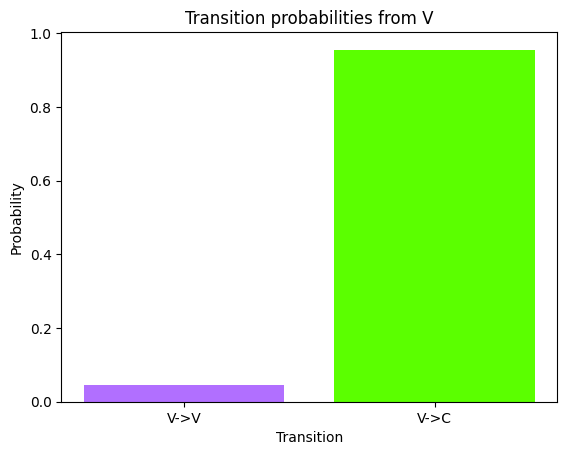

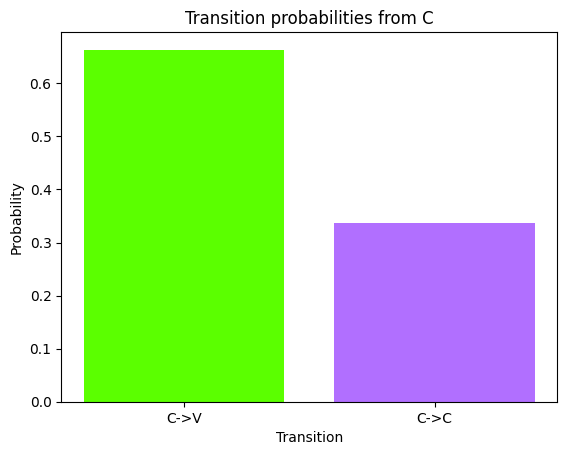

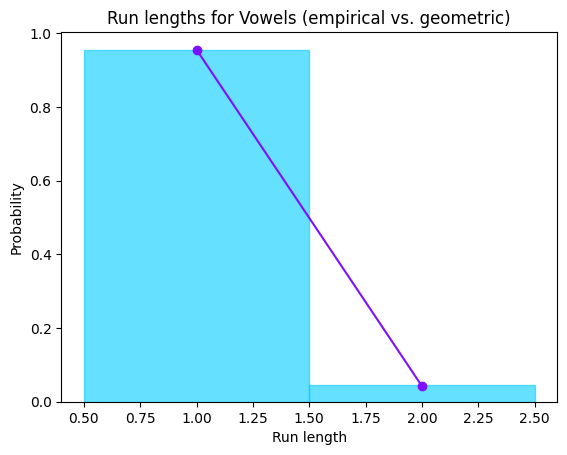

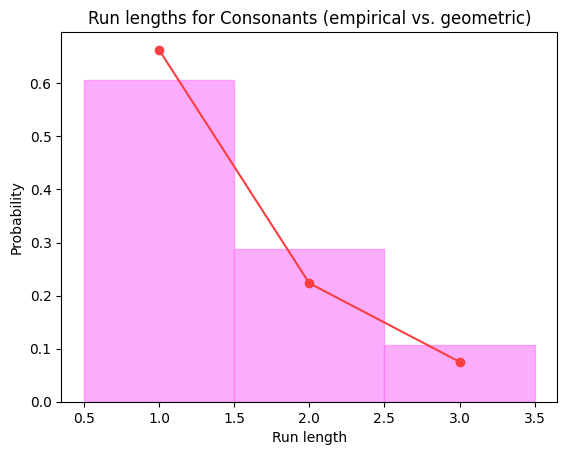

In [11]:
# --- 7. Plots ---
# Transition probabilities from V
plt.figure()
plt.title("Transition probabilities from V")
plt.bar(['V->V', 'V->C'], P[0], color=[ITMO_VIOLET_60, ITMO_GREEN])
plt.xlabel("Transition")
plt.ylabel("Probability")
plt.show()

# Transition probabilities from C
plt.figure()
plt.title("Transition probabilities from C")
plt.bar(['C->V', 'C->C'], P[1], color=[ITMO_GREEN, ITMO_VIOLET_60])
plt.xlabel("Transition")
plt.ylabel("Probability")
plt.show()

# Run lengths for V (histogram + theoretical geometric PMF as a line)
if runs_V:
    plt.figure()
    plt.title("Run lengths for Vowels (empirical vs. geometric)")
    # empirical histogram (normalized)
    bins = np.arange(0.5, min(max_l_V, 15) + 1.5, 1.0)
    plt.hist(runs_V, bins=bins, density=True, alpha=0.6, color=with_alpha(ITMO_CAPRI, 0.45), edgecolor=ITMO_CAPRI)
    # theoretical
    plt.plot(lV, pmfV, marker='o', color=ITMO_VIOLET)
    plt.xlabel("Run length")
    plt.ylabel("Probability")
    plt.show()

# Run lengths for C (histogram + theoretical geometric PMF as a line)
if runs_C:
    plt.figure()
    plt.title("Run lengths for Consonants (empirical vs. geometric)")
    bins = np.arange(0.5, min(max_l_C, 15) + 1.5, 1.0)
    plt.hist(runs_C, bins=bins, density=True, alpha=0.6, color=with_alpha(ITMO_PINK, 0.40), edgecolor=ITMO_PINK)
    plt.plot(lC, pmfC, marker='o', color = ITMO_RED)
    plt.xlabel("Run length")
    plt.ylabel("Probability")
    plt.show()
